<a href="https://colab.research.google.com/github/changsin/MediaEditor/blob/main/notebooks/the_sound_of_silence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Sound of Silence
Simon and Garfunkle's song, [The Sound of Silence](https://youtu.be/NAEppFUWLfc), is a prophetic message about the silent voice of under-represented multitude that still haunts us to this day. The pathos of the song rings far and wide especially after the COVID in the divided world we live in.


I, however, have a more practical use for the sound of silence. There are many occasions when I needed to edit video and audio files mainly to cut out 'unnecessary' portions. Usually, they are those silent moments when there is no sound. I used to manually edit those parts by hand using movie editing tools. Luckily, you can do it easily with a few lines of python code. Below is how you can edit video and audio files using moviepy Python library.

## Download a sample video file

In [1]:
!pip install -q youtube-dl

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


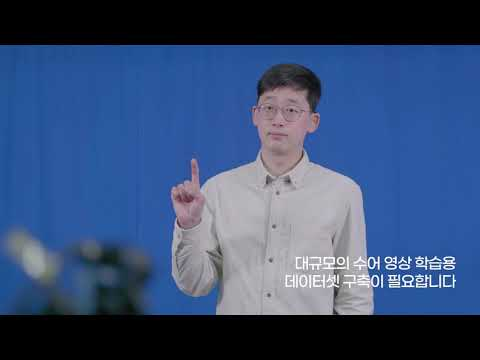

In [23]:
from IPython.display import YouTubeVideo

save_filename = "testworks_sign_lang"
youtube_id = 'R4bEmR5ekq8'
YouTubeVideo(youtube_id)

In [31]:
def download_youtube(youtube_id, save_filename):
  !youtube-dl --output $save_filename".%(ext)s" https://www.youtube.com/watch?v=$youtube_id

download_youtube(youtube_id, save_filename)

[youtube] R4bEmR5ekq8: Downloading webpage
[download] testworks_sign_lang.mp4 has already been downloaded and merged


## Visualize sounds
Once download is complete, let's visualize the sound waves. This can be done by extracting the audio portion from the video file and converting them to a numpy array.

In [32]:
file_in = '/content/{}.mp4'.format(save_filename)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

from moviepy.editor import VideoFileClip, AudioFileClip, concatenate_videoclips

def visualize_sound(audio_array, frame_rate):
    # audio_clip_ar = np.frombuffer(audio, dtype='int16')

    duration = len(audio_array) / frame_rate
    # Find the sound wave timestamps
    time_ar = np.linspace(start=0,
                          stop=duration,
                          num=len(audio_array))

    print(f'duration: {duration} frame_rate: {frame_rate}',
          f'max: {audio_array.max()} min: {audio_array.min()}')

    figure(figsize=(15, 6), dpi=80)
    plt.plot(audio_array)
    plt.show()

duration: 145.1 frame_rate: 44100 max: 0.384552001953125 min: -0.386627197265625


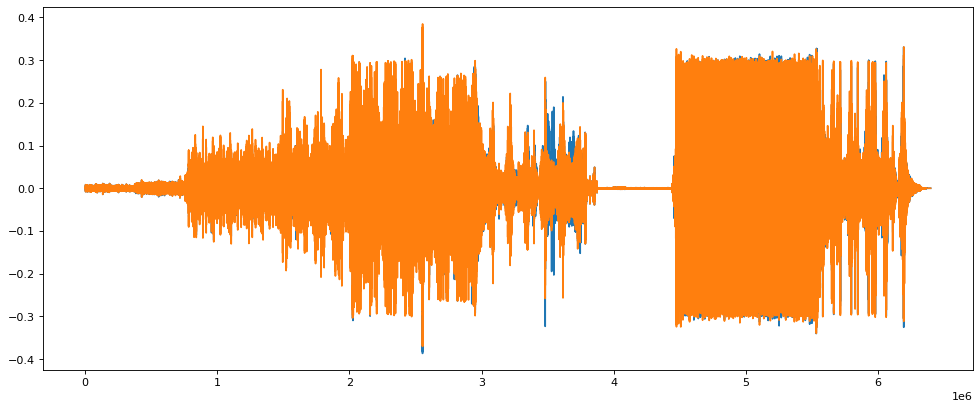

In [41]:
video_clip = VideoFileClip(file_in)

visualize_sound(video_clip.audio.to_soundarray(), video_clip.audio.fps)
video_clip.close()

## Edit out the sound of silence from a video
You can do many interesting things with moviepy like splitting the file into smaller clips, etc. For our purpose, let's just compress the video by removing all the silent parts. Here is the algorithm for the below code#

1. Divide the video into smaller clips. The window size of each clip is specified. 
2. For each clip, check the maximum sound level.
3. If it is above the threshold (sound is there), keep it in a list. Otherwise skip it.
4. Concatenate all the saved clips with sounds.
5. Save the concatenated video into a new file.

You can think of it as moving a moving window and checking if any sound occurred in that window and saving only those clips that have sounds.
Below is the implementation.

In [42]:
import glob
import math
import os

from moviepy.editor import VideoFileClip, AudioFileClip, concatenate_videoclips
# from pydub import AudioSegment

DEFAULT_THRESHOLD = 0.1      # 65 for pydub, 0.01 for moviepy
DEFAULT_WINDOW_SIZE = 0.1


def edit_video(file_in, path_out,
                threshold=DEFAULT_THRESHOLD,
                window_size=DEFAULT_WINDOW_SIZE):
  video_clip = VideoFileClip(file_in)
  video_end = video_clip.end

  n_windows = math.floor(video_end / window_size)
  print(f"Video: {file_in} Duration: {video_end} n_windows: {n_windows}")

  clips_to_save = []

  is_started = False
  start_time = 0
  end_time = 0

  for i in range(n_windows):
    sub_clip = video_clip.audio.subclip(i * window_size, (i + 1) * window_size)
    if sub_clip.max_volume() > threshold:
      if not is_started: # start speaking
          start_time = i * window_size

      is_started = True
    else:
      if is_started:  # speaking ended
          if i < n_windows - 1:
              # add one more window to capture the fade out effect
              end_time = (i + 1) * window_size
              i += 1
          else:
              end_time = video_end
          clips_to_save.append(video_clip.subclip(start_time, end_time))

      is_started = False


  # If the audio track never fades out (kept talking till the end)
  #   take the rest of the audio track.
  # This can happen in two occasions:
  #   1. The entire audio clip is filled with noise - no kept clips
  #   2. There was a moment of silence in the middle
  # but noise started and never ended in silence
  if (len(clips_to_save) == 0 and start_time > 0) or end_time < start_time:
      clips_to_save.append(audio_clip.subclip(start_time, audio_end))

  if len(clips_to_save) > 0:
    edited_video = concatenate_videoclips(clips_to_save)

    edited_video.write_videofile(
        'out.mp4',
        audio_codec='aac',
        threads=16
    )
    edited_video.close()
  else:
    print("###Empty clips ", file_in)

  video_clip.close()

In [43]:
edit_video(file_in, './')

Video: /content/testworks_sign_lang.mp4 Duration: 145.1 n_windows: 1450
[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing audio in outTEMP_MPY_wvf_snd.mp4


100%|██████████| 1729/1729 [00:05<00:00, 337.29it/s]

[MoviePy] Done.
[MoviePy] Writing video out.mp4



100%|██████████| 2353/2353 [05:27<00:00,  7.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 



duration: 78.43 frame_rate: 44100 max: 0.38201904296875 min: -0.37994384765625


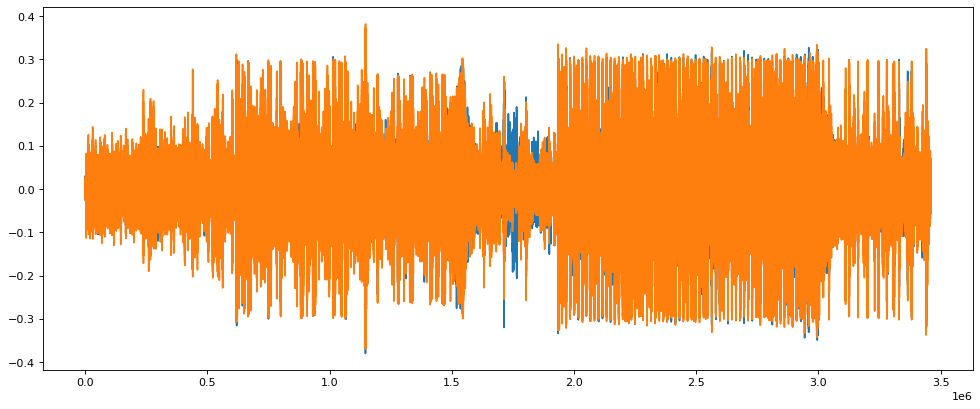

In [44]:
video_out = VideoFileClip("/content/out.mp4")

visualize_sound(video_out.audio.to_soundarray(), video_out.audio.fps)
video_out.close()


In [12]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [13]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)